In [260]:
import torch
import numpy as np
from PIL import Image
from typing import List, Tuple, Optional

def compute_marginals(diversity: torch.Tensor) -> torch.Tensor:

    Phi = diversity  
    
    C = Phi.T @ Phi                      # [D, D]
    print(C.shape)
    A = torch.linalg.inv(C + torch.eye(C.shape[0]))  # [D, D]
    marginals = torch.einsum('nd,dk,nk->n', Phi, A, Phi)  # [N]
    return marginals

import torch
from typing import List, Optional, Tuple

@torch.no_grad()
def sample_low_rank_dpp(
    Phi: torch.Tensor,                      # [N, D]
    return_log_likelihood: bool = False,
    eps: float = 1e-10
) -> Tuple[List[int], Optional[torch.Tensor]]:
    """
    Sample from an L-ensemble DPP with low-rank L = Phi @ Phi.T.

    Returns:
        selected_indices, optional_log_likelihood
    """
    assert Phi.dim() == 2, "Phi must be [N, D]"
    N, D = Phi.shape
    device = Phi.device
    dtype = Phi.dtype

    # Dual kernel C = Phi^T Phi  [D, D]
    C = Phi.transpose(0, 1) @ Phi

    # Eigendecomposition of C
    evals, evecs = torch.linalg.eigh(C)  # ascending
    evals = torch.clamp(evals, min=0.0)

    # Bernoulli selection with p = λ / (1 + λ)
    probs = evals / (evals + 1.0)
    keep = torch.bernoulli(torch.clamp(probs, 0.0, 1.0)).bool()
    k = int(keep.sum().item())

    # Precompute log det(I + C) if asked
    log_norm = None
    if return_log_likelihood:
        I = torch.eye(D, dtype=dtype, device=device)
        chol = torch.linalg.cholesky(I + C)
        log_norm = 2.0 * torch.sum(torch.log(torch.diagonal(chol)))

    # Empty set case
    if k == 0:
        return [], (-log_norm if return_log_likelihood else None)

    # Build V = Phi U Λ^{-1/2}; columns should span the projection DPP subspace
    U = evecs[:, keep]                                 # [D, k]
    lam = torch.clamp(evals[keep], min=eps)            # [k]
    V = Phi @ (U @ torch.diag(lam.rsqrt()))            # [N, k]

    # Tighten orthonormality
    V, _ = torch.linalg.qr(V, mode="reduced")          # [N, k]

    selected: List[int] = []

    # Projection DPP sampling with Householder updates that drop one column per step
    while V.shape[1] > 0:
        # p_i ∝ ||V_i||^2
        row_sq = torch.sum(V * V, dim=1)               # [N]
        total = row_sq.sum()
        if total <= eps:
            break
        i = torch.multinomial((row_sq / total), 1).item()
        selected.append(i)

        # Direction in column space aligned with row i
        vi = V[i, :]                                   # [k]
        nrm = torch.linalg.norm(vi)
        if nrm <= eps:
            # Degenerate; zero out this row and continue
            V[i, :] = 0.0
            # If columns collapsed, exit
            if torch.linalg.matrix_rank(V) < V.shape[1]:
                V, _ = torch.linalg.qr(V, mode="reduced")
            continue

        f = (vi / nrm).reshape(-1, 1)                  # [k,1]

        # Householder reflection H maps f to e1; then drop first column
        # Construct v for H = I - 2 v v^T
        # Choose sign to avoid cancellation
        sign = 1.0 if f[0, 0] >= 0 else -1.0
        u = f.clone()
        u[0, 0] += sign
        u_nrm = torch.linalg.norm(u)
        if u_nrm <= eps:
            # f already aligned with e1
            H = torch.eye(f.numel(), dtype=dtype, device=device) - 2.0 * (f @ f.t())
        else:
            v = u / u_nrm
            H = torch.eye(f.numel(), dtype=dtype, device=device) - 2.0 * (v @ v.t())  # [k,k]

        V = V @ H                                     # [N,k]
        V = V[:, 1:]                                  # drop the e1 column; now [N,k-1]

        # Re-orthonormalize to control drift
        if V.numel() > 0:
            V, _ = torch.linalg.qr(V, mode="reduced")

    # Optional log-likelihood under L-ensemble: log det(L_Y) - log det(I + C)
    log_ll = None
    if return_log_likelihood:
        if len(selected) == 0:
            log_ll = -log_norm
        else:
            Phi_Y = Phi[selected, :]                             # [|Y|, D]
            LY = Phi_Y @ Phi_Y.t()                               # [|Y|, |Y|]
            LY = 0.5 * (LY + LY.t())
            cholY = torch.linalg.cholesky(LY + eps * torch.eye(LY.shape[0], device=device, dtype=dtype))
            log_det_LY = 2.0 * torch.sum(torch.log(torch.diagonal(cholY)))
            log_ll = log_det_LY - log_norm

    return selected, log_ll


@torch.no_grad()
def sample_low_rank_k_dpp(
    Phi: torch.Tensor,                   # [N, D]
    k: int,
    return_log_likelihood: bool = False,
    eps: float = 1e-10
) -> Tuple[List[int], Optional[torch.Tensor]]:
    """
    Sample from a k-DPP with low-rank L = Phi @ Phi.T.

    Returns:
        selected_indices, optional_log_likelihood
    """
    assert Phi.dim() == 2, "Phi must be [N, D]"
    N, D = Phi.shape
    device = Phi.device
    dtype = Phi.dtype

    # Dual kernel C = Phi^T Phi
    C = Phi.T @ Phi

    # Eigendecomposition of C
    evals, evecs = torch.linalg.eigh(C)  # ascending
    evals = torch.clamp(evals, min=0.0)

    # --- k-DPP eigenvector selection via DP on elementary symmetric polynomials ---

    lam = evals.cpu().numpy()
    D = len(lam)
    # DP table for elementary symmetric polynomials
    E = torch.zeros((D + 1, k + 1), dtype=dtype, device=device)
    E[:, 0] = 1.0

    for i in range(1, D + 1):
        lam_i = lam[i - 1]
        for j in range(1, min(i, k) + 1):
            E[i, j] = E[i - 1, j] + lam_i * E[i - 1, j - 1]

    # Sample which eigenvectors to keep
    selected_eigs = []
    rem = k
    for i in reversed(range(D)):
        if rem == 0:
            break
        prob = lam[i] * E[i, rem - 1] / (E[i + 1, rem] + eps)
        if torch.rand(1).item() < prob:
            selected_eigs.append(i)
            rem -= 1
    selected_eigs.reverse()
    keep = torch.zeros(D, dtype=torch.bool, device=device)
    keep[selected_eigs] = True

    # Normalization (log det(I + C)) not used in k-DPP; compute Z_k if requested
    log_norm = None
    if return_log_likelihood:
        log_norm = torch.log(E[D, k] + eps)

    # --- Projection DPP sampling (same as your code) ---

    U = evecs[:, keep]                               # [D, k]
    lam_k = torch.clamp(evals[keep], min=eps)        # [k]
    V = Phi @ (U @ torch.diag(lam_k.rsqrt()))        # [N, k]
    V, _ = torch.linalg.qr(V, mode="reduced")        # orthonormalize

    selected: List[int] = []

    while V.shape[1] > 0:
        # p_i ∝ ||V_i||^2
        row_sq = torch.sum(V * V, dim=1)
        total = row_sq.sum()
        if total <= eps:
            break
        i = torch.multinomial((row_sq / total), 1).item()
        selected.append(i)

        vi = V[i, :]
        nrm = torch.linalg.norm(vi)
        if nrm <= eps:
            V[i, :] = 0.0
            if torch.linalg.matrix_rank(V) < V.shape[1]:
                V, _ = torch.linalg.qr(V, mode="reduced")
            continue

        f = (vi / nrm).reshape(-1, 1)
        sign = 1.0 if f[0, 0] >= 0 else -1.0
        u = f.clone()
        u[0, 0] += sign
        u_nrm = torch.linalg.norm(u)
        if u_nrm <= eps:
            H = torch.eye(f.numel(), dtype=dtype, device=device) - 2.0 * (f @ f.t())
        else:
            v = u / u_nrm
            H = torch.eye(f.numel(), dtype=dtype, device=device) - 2.0 * (v @ v.t())

        V = V @ H
        V = V[:, 1:]
        if V.numel() > 0:
            V, _ = torch.linalg.qr(V, mode="reduced")

    # --- Optional log-likelihood ---
    log_ll = None
    if return_log_likelihood:
        Phi_Y = Phi[selected, :]
        LY = Phi_Y @ Phi_Y.T
        LY = 0.5 * (LY + LY.T)
        cholY = torch.linalg.cholesky(LY + eps * torch.eye(LY.shape[0], device=device, dtype=dtype))
        log_det_LY = 2.0 * torch.sum(torch.log(torch.diagonal(cholY)))
        log_ll = log_det_LY - log_norm

    return selected, log_ll

def load_slide_features(ds, slide_idx: int):
    """
    Return (features [N, D], coords [N, 2]) for one slide.
    Features are loaded from .npy files (NumPy arrays).
    """
    rec = ds.records[slide_idx]

    feat_list = []
    for furi in rec.feature_uris:
        if furi is None:
            continue
        fpath = ds.root / furi
        f = np.load(fpath)                 # (D,)
        feat_list.append(f)

    if not feat_list:
        raise RuntimeError(f"No features found for slide {rec.slide_id}")

    feats = np.stack(feat_list, axis=0)    # [N, D]
    coords = rec.coords.astype(np.float32) # [N, 2]
    return feats, coords

import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_marginals(coords, marginals, tile_size=128, sigma=1.5):
    """
    Scatter marginals back into a 2D heatmap for visualization.
    Args:
        coords (np.ndarray or torch.Tensor): [N,2] tile coordinates (x,y)
        marginals (torch.Tensor): [N] marginal scores
        tile_size (int): pixel spacing between neighboring tiles
        sigma (float): Gaussian blur to smooth the map
    """
    coords = np.asarray(coords)
    m = marginals.detach().cpu().numpy()

    # normalize to [0,1] for display
    m = (m - m.min()) / (m.max() - m.min() + 1e-8)

    # compute grid size
    max_x, max_y = coords.max(0).astype(int)
    H = max_y // tile_size + 1
    W = max_x // tile_size + 1

    heatmap = np.zeros((H, W), dtype=np.float32)

    # fill in tile centers
    for (x, y), val in zip(coords, m):
        i = int(y // tile_size)
        j = int(x // tile_size)
        heatmap[i, j] = val

    return heatmap

def show_thumbnail_and_heatmap(ds, slide_idx: int, heatmap: np.ndarray, coords=None, selected_indices=None, tile_size=128):
    rec = ds.records[slide_idx]
    thumb = Image.open(ds.root / rec.lowres_uri).convert("RGB")
    thumb = np.array(thumb)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # --- thumbnail ---
    axs[0].imshow(thumb)
    axs[0].set_title(f"{rec.slide_id} Thumbnail")
    axs[0].axis("off")

    # --- heatmap ---
    im = axs[1].imshow(heatmap.T, cmap="inferno", origin="upper")
    axs[1].set_title("DPP Marginals Heatmap")
    axs[1].axis("off")

    # --- scatter sampled tiles (only on heatmap) ---
    if coords is not None and selected_indices is not None:
        sel = np.asarray(coords)[selected_indices]
        axs[1].scatter(
            sel[:, 1] / tile_size,
            sel[:, 0] / tile_size,
            s=35,
            edgecolor="cyan",
            facecolor="none",
            linewidth=1.2,
        )

    # --- colorbar ---
    cbar = fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
    cbar.set_label("Marginal Inclusion Probability", rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()
def visualize_sample_on_thumbnail(ds, slide_idx, coords, marginals, selected_indices, tile_size=128, cmap="inferno"):
    """
    Show slide thumbnail and DPP marginals (with sampled tiles highlighted).

    Args:
        ds: dataset object with .records and .root / .lowres_uri for thumbnail lookup
        slide_idx (int): slide index
        coords (np.ndarray or torch.Tensor): [N,2] tile coordinates (x,y)
        marginals (torch.Tensor): [N] marginal scores
        selected_indices (list[int]): sampled tile indices
        tile_size (int): spacing between neighboring tiles
        cmap (str): colormap for marginals heatmap
    """
    # --- Load thumbnail ---
    rec = ds.records[slide_idx]
    thumb = Image.open(ds.root / rec.lowres_uri).convert("RGB")
    thumb = np.array(thumb)

    # --- Build heatmap ---
    coords = np.asarray(coords)
    m = marginals.detach().cpu().numpy()
    m = (m - m.min()) / (m.max() - m.min() + 1e-8)

    max_x, max_y = coords.max(0).astype(int)
    H = max_y // tile_size + 1
    W = max_x // tile_size + 1
    heatmap = np.zeros((H, W), dtype=np.float32)

    for (x, y), val in zip(coords, m):
        i = int(y // tile_size)
        j = int(x // tile_size)
        heatmap[i, j] = val

    # --- Prepare figure ---
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Left: thumbnail with sampled tiles
    axs[0].imshow(thumb)
    selected_coords = coords[selected_indices]
    axs[0].scatter(
        selected_coords[:, 1],
        selected_coords[:, 0],
        s=30,
        edgecolor="cyan",
        facecolor="none",
        linewidth=1.2,
    )
    axs[0].set_title(f"{rec.slide_id} Thumbnail + Sampled Tiles")
    axs[0].axis("off")

    # Right: heatmap with samples
    axs[1].imshow(heatmap.T, cmap=cmap, origin="upper")
    axs[1].scatter(
        selected_coords[:, 0] / tile_size,
        selected_coords[:, 1] / tile_size,
        s=30,
        edgecolor="cyan",
        facecolor="none",
        linewidth=1.2,
    )
    axs[1].set_title("DPP Marginals + Sampled Tiles")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2

import sys 
from torch.utils.data import DataLoader

sys.path.append("..")
from src.data.datasets import SlideDataset, slide_collate

ds = SlideDataset(
    root="/home/alpaca/Documents/van/wsi_sampling/data/toy_set",
    split="train",
    features_parquet_rel="features.parquet",  # <- single parquet index
    load_mode="both",
)

loader = DataLoader(
    ds,
    batch_size=1,
    collate_fn=slide_collate,
    num_workers=0,
)

# --- get one slide ---
batch = next(iter(loader))
print(batch['views'][0].fetch())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[SlideDataset] Merged features for 358 slides.


TypeError: SlideFeatureView.fetch() missing 1 required positional argument: 'idxs'

torch.Size([64, 8])
torch.Size([8, 8])


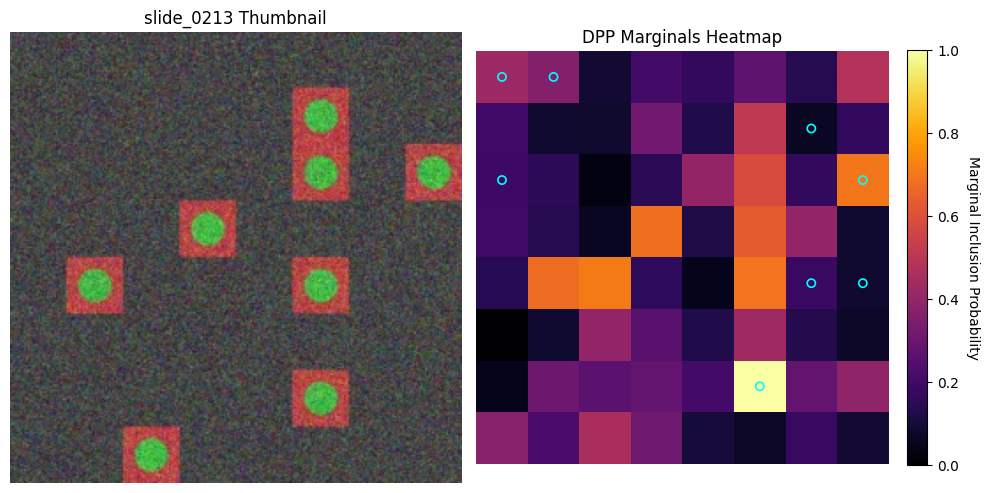

torch.Size([2048, 2048])


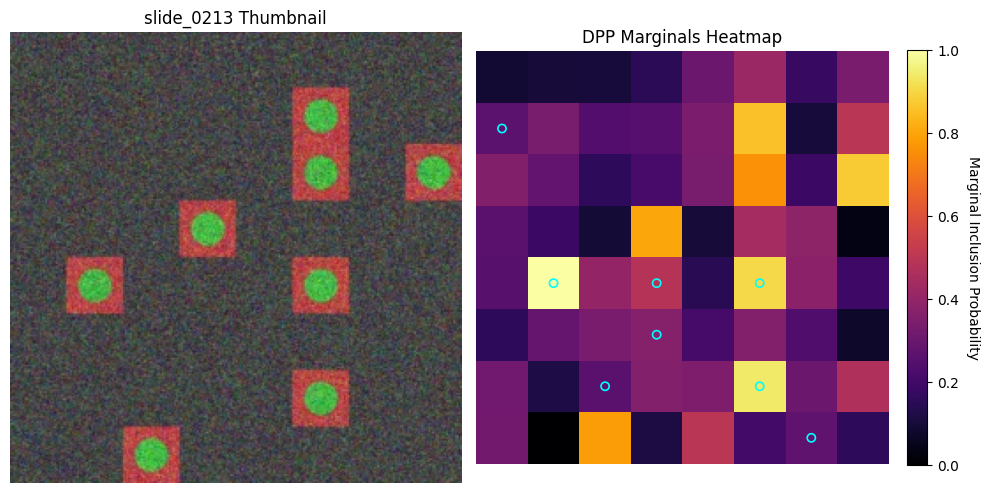

In [280]:
from sklearn.decomposition import PCA

idx = np.random.randint(len(ds))

# --- load features ---
feats, coords = load_slide_features(ds, slide_idx=idx)


# --- compute marginals ---
feats_torch = torch.from_numpy(feats)
W = torch.randn(2048, 8)
out = feats_torch @ W
print(out.shape)
marginals = compute_marginals(out)
sample = sample_low_rank_dpp(out, return_log_likelihood=False)[0]

heatmap = visualize_marginals(coords, marginals)
show_thumbnail_and_heatmap(ds, slide_idx=idx, heatmap=heatmap, coords=coords, selected_indices=sample)

marginals_full = compute_marginals(feats_torch)
heatmap_full = visualize_marginals(coords, marginals_full)

sample_k = sample_low_rank_k_dpp(feats_torch, k=8, return_log_likelihood=False)[0]
show_thumbnail_and_heatmap(ds, slide_idx=idx, heatmap=heatmap_full, coords=coords, selected_indices=sample_k)




In [17]:
feats_torch.shape

torch.Size([64, 2048])

In [241]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

def test_feature_diversity(ds, n_slides: int = 10, max_tiles: int = 256):
    """
    Sample a few slides and check feature variance and inter-slide similarity.
    """
    n_slides = min(n_slides, len(ds))
    results = []

    print(f"Testing {n_slides} slides for feature diversity...")
    for idx in tqdm(range(n_slides)):
        feats, coords = load_slide_features(ds, slide_idx=idx)
        feats = torch.from_numpy(feats)
        if feats.shape[0] > max_tiles:
            feats = feats[torch.randperm(feats.shape[0])[:max_tiles]]

        # Normalize per feature vector
        feats_norm = feats / (feats.norm(dim=1, keepdim=True) + 1e-8)

        # Compute intra-slide variance
        var = feats_norm.var(dim=0).mean().item()
        results.append({"slide_idx": idx, "var": var})

    vars_ = [r["var"] for r in results]
    print(f"\nMean feature variance across slides: {np.mean(vars_):.4e}")
    print(f"Per-slide variance (normalized features): {[f'{v:.4e}' for v in vars_]}\n")

    # --- check inter-slide similarity ---
    pooled_feats = []
    for idx in range(n_slides):
        feats, _ = load_slide_features(ds, slide_idx=idx)
        f = torch.from_numpy(feats).mean(dim=0, keepdim=True)
        f = f / (f.norm() + 1e-8)
        pooled_feats.append(f)
    pooled_feats = torch.cat(pooled_feats, dim=0)
    sim = cosine_similarity(pooled_feats.numpy())

    print("Inter-slide mean cosine similarity matrix:")
    print(np.round(sim, 3))

    return np.mean(vars_), sim

Testing 8 slides for feature diversity...


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 204.69it/s]


Mean feature variance across slides: 5.4621e-05
Per-slide variance (normalized features): ['5.5073e-05', '5.4253e-05', '5.5073e-05', '5.4253e-05', '5.4253e-05', '5.4732e-05', '5.5073e-05', '5.4253e-05']

Inter-slide mean cosine similarity matrix:
[[1.    0.983 1.    0.983 0.983 0.996 1.    0.983]
 [0.983 1.    0.983 1.    1.    0.996 0.983 1.   ]
 [1.    0.983 1.    0.983 0.983 0.996 1.    0.983]
 [0.983 1.    0.983 1.    1.    0.996 0.983 1.   ]
 [0.983 1.    0.983 1.    1.    0.996 0.983 1.   ]
 [0.996 0.996 0.996 0.996 0.996 1.    0.996 0.996]
 [1.    0.983 1.    0.983 0.983 0.996 1.    0.983]
 [0.983 1.    0.983 1.    1.    0.996 0.983 1.   ]]


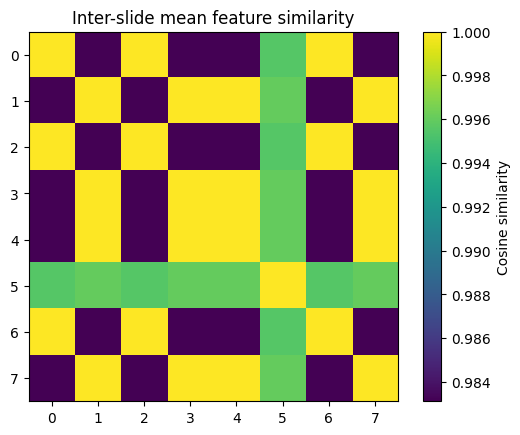

In [275]:
mean_var, sim = test_feature_diversity(ds, n_slides=8)

# Optional: visualize inter-slide similarity
import matplotlib.pyplot as plt
plt.imshow(sim, cmap="viridis")
plt.colorbar(label="Cosine similarity")
plt.title("Inter-slide mean feature similarity")
plt.show()

In [243]:
from torchvision.models import resnet50, ResNet50_Weights
m = resnet50(weights=ResNet50_Weights.DEFAULT)
print(m.conv1.weight.mean(), m.conv1.weight.std())

tensor(-0.0006, grad_fn=<MeanBackward0>) tensor(0.2693, grad_fn=<StdBackward0>)
